<a href="https://colab.research.google.com/github/KIYONG30/KIYONG30/blob/main/(201700467_%EA%B9%80%EA%B8%B0%EC%9A%A9)%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%96%B8%EC%96%B4_%EB%B6%84%EB%A5%98_with_BERT_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT을 통한 딥러닝 분류 학습

사용 알고리즘:  BERT Fine-Tuning Tutorial with PyTorch
-> https://mccormickml.com/2019/07/22/BERT-fine-tuning

사용 데이터: Naver sentiment movie corpus v1.0
https://github.com/e9t/nsmc.git







* 본 내용은 https://github.com/deepseasw/bert-naver-movie-review 를 토대로 수정하였습니다. deepseasw님께 감사 드립니다.


In [ ]:
#@title 환경설정

# Hugging Face의 트랜스포머 모델을 설치
!pip install transformers

import sys

from IPython.display import clear_output
clear_output(wait=True)

## 관련 라이브러스 설치
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

clear_output()

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

Python version :  3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
TensorFlow version :  2.4.1
Keras version :  2.4.3


## 데이터 불러오기

In [1]:
#@title 데이터 불러오기 - Naver sentiment movie corpus v1.0
구글드라이브ID = '1LqlOjAaceAyQrj8fzfcBqBRiXZ4BcFUH'  #@param {type: "string"}
파일저장이름 = '\uAC8C\uC784 \uB9AC\uBDF0 \uC218\uC815.csv'  #@param {type: "string"}

## 데이터 출처: Naver sentiment movie corpus v1.0
## https://github.com/e9t/nsmc


# 구글 드라이브 연결을 위한 기본 세팅
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 문서 ID로 실제 파일 불러오는 법
## https://drive.google.com/open?id=1EbnxOYEt4PJxVN_z1SO2iLMSw4JSkmdV
###label,text
###긍정,어릴때보고 지금다시봐도 재밌어요ㅋㅋ
###긍정,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다."
###긍정,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.
###부정,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.
###부정,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ
###부정,포풍저그가나가신다영차영차영차

# 실습을 위한 간단 데이터 - 긍정 100개 부정 100개
# https://drive.google.com/open?id=1pHM41cWacOvMT5bl7TGTmxMLL_tl6M6n
rawdata_downloaded = drive.CreateFile({'id': 구글드라이브ID })
rawdata_downloaded.GetContentFile(파일저장이름)

## 하단은 Full DATA - 긍정 99,996개 부정 99,996개
## https://drive.google.com/open?id=1EbnxOYEt4PJxVN_z1SO2iLMSw4JSkmdV
#rawdata_downloaded = drive.CreateFile({'id': '1EbnxOYEt4PJxVN_z1SO2iLMSw4JSkmdV'})
#rawdata_downloaded.GetContentFile('rawdata.txt')

print(파일저장이름+"을 정상적으로 가져왔습니다.")

# 파일을 DataFrame으로 전환
df = pd.read_csv(파일저장이름, sep='\t')
df

게임 리뷰 수정.csv을 정상적으로 가져왔습니다.


NameError: ignored

In [ ]:
#@title 데이터 선택하기

데이터량 = "100000"  #@param ['100', '1000', '5000','10000', '100000', '199991']
데이터량 = int(데이터량)

df = df.iloc[:데이터량]
print(df)

print(df["label"].groupby([df["label"]]).count())



                                                   text label
0                                   아 더빙.. 진짜 짜증나네요 목소리    부정
1                     흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나    긍정
2                                     너무재밓었다그래서보는것을추천한다    부정
3                         교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정    부정
4     사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...    긍정
...                                                 ...   ...
9995  곰티비로 무료로 봤기때문에 5점주려고했는데 1 한국 공포영화의 특징인 깜놀시키려 하...    부정
9996  이딴걸드라마라고썼냐 수습할수없으면걍친자녀아니면되고 간단하네 얼굴을바꿨으면 결말이라도...    부정
9997                              왠지 김연아 크면 에리카처럼 될것같음.    긍정
9998          솔직히 굿 ㅋㅋㅋㅋ 넘버11씨는 살아남길 바랬는데 2번째극장판 어서 나오길    긍정
9999                                      그냥보다나옴 노답 핵노잼    부정

[10000 rows x 2 columns]
label
긍정    4979
부정    5021
Name: label, dtype: int64


In [ ]:
## 텍스트로 되어 있는 라벨을 숫자로 변환
df.loc[df.label=='긍정', 'label']='1'
df.loc[df.label=='부정', 'label']='0'
#df.loc[df.label=='분류추가', 'label']='2'

## label 값을 숫자로 전환
df['label'] = df['label'].apply(pd.to_numeric) 

print(df)


                                                   text  label
0                                   아 더빙.. 진짜 짜증나네요 목소리      0
1                     흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2                                     너무재밓었다그래서보는것을추천한다      0
3                         교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4     사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
...                                                 ...    ...
9995  곰티비로 무료로 봤기때문에 5점주려고했는데 1 한국 공포영화의 특징인 깜놀시키려 하...      0
9996  이딴걸드라마라고썼냐 수습할수없으면걍친자녀아니면되고 간단하네 얼굴을바꿨으면 결말이라도...      0
9997                              왠지 김연아 크면 에리카처럼 될것같음.      1
9998          솔직히 굿 ㅋㅋㅋㅋ 넘버11씨는 살아남길 바랬는데 2번째극장판 어서 나오길      1
9999                                      그냥보다나옴 노답 핵노잼      0

[10000 rows x 2 columns]


In [ ]:
#@title 훈련 데이터 비율 선택하기

훈련데이터비율 = 0.9  #@param ['0.9', '0.8', '0.7', '0.6']

## 훈련데이터와 테스트데이터로 분리
train=df.sample(frac=훈련데이터비율,random_state=200)
test=df.drop(train.index)

train.drop_duplicates(subset = ['text'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
train['text'] = train['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
train['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train = train.dropna(how='any') # Null 값 제거
print('전처리 후 훈련용 샘플의 개수 :',len(train))

test.drop_duplicates(subset = ['text'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
test['text'] = test['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test))


전처리 후 훈련용 샘플의 개수 : 8898
전처리 후 테스트용 샘플의 개수 : 993


## 데이터 전처리 with bert

In [ ]:
#@title 학습 데이터 처리 - BERT형식으로 변환

# 리뷰 문장 추출
sentences = train['text']
print('')
print('##### 원본 데이터 #####')
print(sentences[:10])

# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
print('')
print('##### Bert 형식으로 변환 #####')
print(sentences[:10])


# 라벨 추출
labels = train['label'].values

print('')
print('##### 라벨 추출 #####')
print(labels)


##### 원본 데이터 #####
8159                                        따뜻하고 잔잔해요 좋네요
6332    공포영화 즐겨보는한사람으로써 영화먼저보고 평점봤는데 이건아닌거같아 평점 깍기위해 점...
8895                                제목부터 내용까지 손볼 게 하나도 없네
5351                                        쩝쩝 쩝 하다가 결국 쩝
4314                                   교훈과 로맨스를 동시에 갖춘 영화
3987            역사지식조금만있어도 재미있게 보는 영화천일의 앤이랑 비교해서보면 더재미있다
3300                         재밌어요 박보영 언니 사랑해요 박소담 언니 연기잘함
370     초딩 때 친척형이 비디오로 빌려와서 봤던 기억이 난다너무 재미 없었다 근데 나중에 ...
7647                                        이런드라마가 많이 나오길
4763                                             달고나 커플지대
Name: text, dtype: object

##### Bert 형식으로 변환 #####
['[CLS] 따뜻하고 잔잔해요 좋네요 [SEP]', '[CLS] 공포영화 즐겨보는한사람으로써 영화먼저보고 평점봤는데 이건아닌거같아 평점 깍기위해 점줌 처음부터 끝까지 인칭을하려면 제대로하지 왜 시체를 찍고ㅋㅋ애들 라면먹을때 그럼 카메라감독이 혼자 층에서찍었다고 오뚝이 발로건들여놓고 무서워하던 사람이 [SEP]', '[CLS] 제목부터 내용까지 손볼 게 하나도 없네 [SEP]', '[CLS] 쩝쩝 쩝 하다가 결국 쩝 [SEP]', '[CLS] 교훈과 로맨스를 동시에 갖춘 영화 [SEP]', '[CLS] 역사지식조금만있어도 재미있게 보는 영화천일의 앤이랑 비교해서보면 더재미있다 [SEP]', '[CLS] 재밌어요 박보

![대체 텍스트](https://mino-park7.github.io/images/2019/02/bert-input-representation.png)

BERT의 입력은 위의 그림과 같은 형식입니다. Classification을 뜻하는 [CLS] 심볼이 제일 앞에 삽입됩니다. 파인튜닝시 출력에서 이 위치의 값을 사용하여 분류를 합니다. [SEP]은 Seperation을 가리키는데, 두 문장을 구분하는 역할을 합니다. 이 예제에서는 문장이 하나이므로 [SEP]도 하나만 넣습니다.
<br>
<br>
<br>

In [ ]:
#@title 학습 데이터 처리 - BERT로 임베딩하기

bert모델 = "bert-base-multilingual-cased"  #@param ['bert-base-multilingual-cased', 'bert-large-cased', 'bert-base-chinese']

#"bert-base-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json",
#"bert-large-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json",
#"bert-base-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json",
#"bert-large-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json",
#"bert-base-multilingual-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json",
#"bert-base-multilingual-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json",
#"bert-base-chinese": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json",
#"bert-base-german-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-cased-config.json",
#"bert-large-uncased-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-config.json",
#"bert-large-cased-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-config.json",
#"bert-large-uncased-whole-word-masking-finetuned-squad": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-finetuned-squad-config.json",
#"bert-large-cased-whole-word-masking-finetuned-squad": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-finetuned-squad-config.json",
#"bert-base-cased-finetuned-mrpc": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-finetuned-mrpc-config.json",
#"bert-base-german-dbmdz-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-cased-config.json",
#"bert-base-german-dbmdz-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-uncased-config.json",
#"bert-base-japanese": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-config.json",
#"bert-base-japanese-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking-config.json",
#"bert-base-japanese-char": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-config.json",
#"bert-base-japanese-char-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-whole-word-masking-config.json",
#"bert-base-finnish-cased-v1": "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-cased-v1/config.json",
#"bert-base-finnish-uncased-v1": "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-uncased-v1/config.json",


# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 따뜻하고 잔잔해요 좋네요 [SEP]
['[CLS]', '따', '##뜻', '##하고', '잔', '##잔', '##해', '##요', '좋', '##네', '##요', '[SEP]']


BERT는 형태소분석으로 토큰을 분리하지 않습니다. WordPiece라는 통계적인 방식을 사용합니다. 한 단어내에서 자주 나오는 글자들을 붙여서 하나의 토큰으로 만듭니다. 이렇게 하면 언어에 상관없이 토큰을 생성할 수 있다는 장점이 있습니다. 또한 신조어 같이 사전에 없는 단어를 처리하기도 좋습니다. 

위의 결과에서 ## 기호는 앞 토큰과 이어진다는 표시입니다. 토크나이저는 여러 언어의 데이터를 기반으로 만든 'bert-base-multilingual-cased'를 사용합니다. 그래서 한글도 처리가 가능합니다.
<br>
<br>
<br>

리뷰의 최대 길이 : 152
리뷰의 평균 길이 : 45.109912339851654


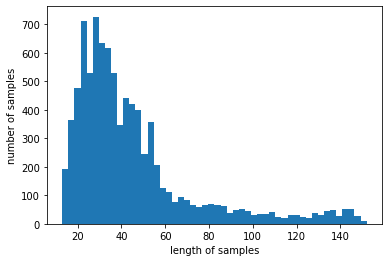

전체 샘플 중 길이가 128 이하인 샘플의 비율: 96.53854798831199


In [ ]:
#@title 전처리를 위한 문장 길이 조회

## 전처리를 위한 기본 텍스트 정보를 탐색합니다.

최대길이 = "128"  #@param ['32', '64', '128', '256']
최대길이 = int(최대길이)

print('리뷰의 최대 길이 :',max(len(l) for l in sentences))
## 리뷰의 최대 길이는 가장 긴 리뷰 문장의 길이를 의미합니다.

print('리뷰의 평균 길이 :',sum(map(len, sentences))/len(sentences))
## 리뷰의 평균 길이는 리뷰 문장 길이의 평균값을 의미합니다.

import matplotlib.pyplot as plt

plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 문장 길이 전체 그래프를 살펴보면, 리뷰 문장의 전체 분포를 볼 수 있습니다.
## 대다수의 문장이 60자 이하인 것을 알 수 있습니다.


def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))


max_len = 최대길이
below_threshold_len(max_len, sentences) 

## max_leb(문장 최대 길이)가 128일때 선택되는 전체 데이터량을 의미합니다.
## 현재값은 95.92로 대략 6%를 제외한 모든 데이터가 선택된 것을 확인할 수 있습니다.

In [ ]:
#@title 패딩 및 어텐션 마스크 세팅

# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 최대길이

## 입력 문장의 최대 길이를 지정해줍니다. 
## 물론 어떤 리뷰는 128자 이상이기도 합니다. 하지만 효율성을 위해서 고정해줍니다.
## MAX_LEN을 256, 512 등 더 크게 변경할 수도 있습니다. 그러면 처리 시간이 더 걸립니다. 대신 정확도는 상승합니다.
## 반대로 MAX_LEN을 64, 32 등 더 작게 변경할 수도 있습니다. 그러면 처리 시간은 짦아지고, 정확도는 줄어듭니다.
## MAX_LEN에 "정답"은 없습니다. 적절한 길이를 선택해야 합니다.

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
## 패딩이란 MAX_LEN보다 짦은 문장에 적용합니다. 문장 길이가 120이라면 8개가 패딩으로 채워지게 됩니다.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

print(input_ids[0])

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[   101   9130 118848  12453   9653 119196  14523  48549   9685  77884
  48549    102      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
#@title 훈련데이터와 테스트 데이터 분리 및 배치 세팅

검증데이터비율 = "0.2"  #@param ['0.1', '0.2', '0.3']

배치크기 = 32  #@param ['32', '64', '128', '256']
배치크기 = int(배치크기)


# 훈련셋과 검증셋으로 분리
validation_size = 검증데이터비율
## 훈련셋과 검증셋은 9:1로 분리해줍니다. 숫자를 변경하면 비율을 변경할 수 있습니다.

random_state = 1
## 컴퓨터에서의 분리는 시간값을 토대로 하는 랜덤입니다. 
## 하지만 완전히 랜덤으로 하면 학습마다 다른 결과가 나오는 문제가 발생합니다.
## 이를 통제하기 위해서 랜덤 시작값을 세팅해줍니다.

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=random_state, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=random_state, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print("##### 훈련 텍스트의 bert embedding값 #####")
print(train_inputs[0])
print("##### 훈련 텍스트의 label 값 #####")
print(train_labels[0])
print("##### 훈련 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(train_masks[0])
print("##### 검증 텍스트의 bert embedding값 #####")
print(validation_inputs[0])
print("##### 검증 텍스트의 label 값 #####")
print(validation_labels[0])
print("##### 검증 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(validation_masks[0])


# 배치 사이즈
batch_size = 배치크기

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)



##### 훈련 텍스트의 bert embedding값 #####
tensor([  101,  9451, 33077, 18108,  9659, 22458, 39218,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,

In [ ]:
#@title 테스트 데이터 처리(훈련데이터와 동일)

# 리뷰 문장 추출
sentences = test['text']

# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

# 라벨 추출
labels = test['label'].values

# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=최대길이, dtype="long", truncating="post", padding="post")

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=배치크기)

## 모델 세팅

In [ ]:
#@title GPU 세팅

## 해당 부분에서 에러가 나면, "런타임 > 런타임 유형 변경 > 하드웨어 가속시 > GPU"로 변경해야 합니다.

# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
#@title 딥러닝 모델 세팅

# 분류를 위한 BERT 모델 생성
## 이미 bert를 통한 분류 모델이 만들어져 있습니다. 모델을 불러오기만 하면 됩니다.
## num_labels를 통해서 분류 갯수를 지정해줍니다. 저희는 긍정-부정의 2개 분류이기에 2입니다.

분류갯수 = "2"  #@param ['2', '3', '4', '5']
분류갯수 = int(분류갯수)

epochs수 = 4  #@param ['2', '3', '4', '5']
epochs수 = int(epochs수)

model = BertForSequenceClassification.from_pretrained(bert모델, num_labels=분류갯수)
model.cuda()

# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수 
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)




Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
#@title 딥러닝 모델 간략 보기

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## 모델 학습

In [ ]:
#@title 딥러닝 학습

# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


## 본격적으로 딥러닝 학습을 수행하게 됩니다. 
## 현재 150000개의 데이터로는 1 epoch 50분 정도의 시간이 소요됩니다.
## 4번의 epoch이기에 약 200분, 3시간이 넘는 학습 시간이 필요합니다.
## 연습을 하실 때에는 1000개 정도로 데이터량을 줄여서 테스트 해보실 것을 권장드립니다.

from tqdm.notebook import tqdm

# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시 / 매 40  batch 마다
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        
        # 그래디언트 초기화
        model.zero_grad()
       
        # Forward 수행   
        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        # 총 로스 계산
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = output[0]
        total_train_loss += loss.item()
        logits = output[1]

        # Backward 수행으로 그래디언트 계산
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # 그래디언트 클리핑
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # 스케줄러로 학습률 감소
        # Update the learning rate.
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss  / len(train_dataloader) 

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        
        # 로스 구함
        loss = output.loss
        total_eval_loss += loss.item()
        logits = output.logits

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training. Accur': avg_val_accuracy,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.57
  Training epcoh took: 0:02:58

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.49
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.41
  Training epcoh took: 0:03:02

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.45
  Validation took: 0:00:07

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.30
  Training epcoh took: 0:03:02

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.51
  Validation took: 0:00:07

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.22
  Training epcoh took: 0:03:02

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.51
  Validation took: 0:00:07

Training complete!
Total training took 0:12:32 (h:mm:ss)


       Training Loss  Valid. Loss  Training. Accur  Valid. Accur. Training Time Validation Time
epoch                                                                                          
1               0.57         0.49             0.76           0.76       0:02:58         0:00:07
2               0.41         0.45             0.79           0.79       0:03:02         0:00:07
3               0.30         0.51             0.80           0.80       0:03:02         0:00:07
4               0.22         0.51             0.80           0.80       0:03:02         0:00:07


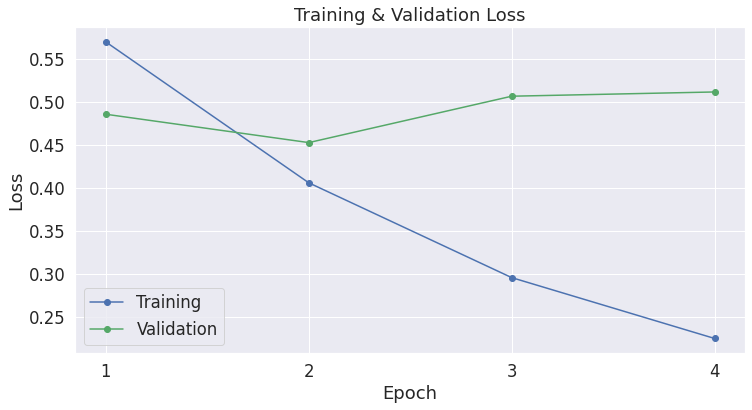

In [ ]:
#@title 딥러닝 학습 간단 보기

import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
print(df_stats.to_string())


import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()




##### 테스트 모델을 통한 모델 정확도 #####
Accuracy: 0.81
Test took: 0:00:08

              precision    recall  f1-score   support

         pos       0.78      0.81      0.79       470
         neg       0.82      0.80      0.81       523

    accuracy                           0.80       993
   macro avg       0.80      0.80      0.80       993
weighted avg       0.80      0.80      0.80       993




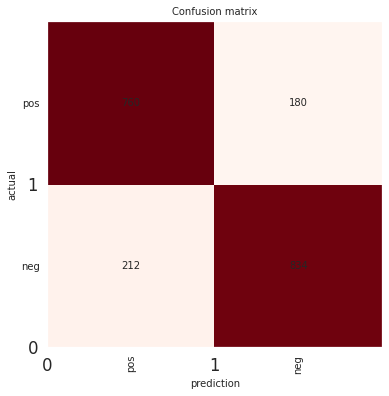

In [ ]:
#@title 딥러닝 학습 평가하기

라벨링 = ['pos','neg']  #@param


#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()


# Tracking variables 
predictions , true_labels, predictionsfin = [], [], []

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("##### 테스트 모델을 통한 모델 정확도 #####")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


## 테스트 데이터를 대상으로 하는 모델 상세 평가
## precision = 정밀도 = 실제로는 False이지만 True로 라벨링 한 것에 집중
## 실제로는 스팸메일이 아니지만 스펨 메일로 라벨링하면?!
## recall = 재현율 = 실제 True인데 False 라벨링한 것에 집중
## 실제로는 코로나 감염자이지만, 코로나 감염이 아니라고 하면?!
## F1 = 정밀도와 재현율의 조화평균

rounded_labels_set = []
rounded_predictions_set = []

from sklearn.metrics import classification_report

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  rounded_labels = np.argmax(predictions[i], axis=1).flatten()
  rounded_labels_set.extend(rounded_labels)
  # Calculate and store the coef for this batch.  
  rounded_predictions = true_labels[i].flatten()     
  rounded_predictions_set.extend(rounded_predictions)

labels = 라벨링

print("")
print(classification_report(rounded_labels_set, rounded_predictions_set, target_names=labels))
print("")


## 혼란 매트릭스 - Confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  rounded_labels = np.argmax(predictions[i], axis=1).flatten()
  rounded_labels_set.extend(rounded_labels)
  # Calculate and store the coef for this batch.  
  rounded_predictions = true_labels[i].flatten()     
  rounded_predictions_set.extend(rounded_predictions)   

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels_set, rounded_predictions_set)

def plot_confusion_matrix(
    ax, matrix, labels, title='Confusion matrix', fontsize=9):

    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])

    # Place labels on minor ticks
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation='90', fontsize=fontsize, minor=True)
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)

    # Hide major tick labels
    ax.tick_params(which='major', labelbottom='off', labelleft='off')

    # Finally, hide minor tick marks
    ax.tick_params(which='minor', width=0)

    # Plot heat map
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Reds)

    # Plot counts as text
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Add finishing touches
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)

    plt.show()


if __name__ == '__main__':
    matrix = cm
    labels = 라벨링
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    plot_confusion_matrix(ax, matrix, labels, fontsize=10)

## 예측 모델 실전 테스트#

In [ ]:
#@title 딥러닝 모델로 예측하기


테스트용텍스트 = '\u314B\u314B\u314B\u314B \uC774\uB7F0\uAC8C \uC601\uD654\uC57C?'  #@param {type: "string"}

# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

logits = test_sentences([테스트용텍스트])

print(logits)
print(np.argmax(logits))

[[ 0.03511592 -0.18220215]]
0


In [ ]:
#@title 딥러닝 모델로 예측하기


테스트용텍스트 = '\uC640... \uC815\uB9D0... \uB108\uBB34 \uC88B\uC558\uB2E4'  #@param {type: "string"}

# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

logits = test_sentences([테스트용텍스트])

print(logits)
print(np.argmax(logits))

[[-2.9432845  2.7092736]]
1


## 딥러닝 모델의 저장 & 불러오기

In [ ]:
#@title 딥러닝 모델 저장하기

model.save_pretrained('.')

## 딥러닝 모델 저장하기
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!cp "/content/pytorch_model.bin" -r "/content/drive/My Drive"
!cp "/content/config.json" -r "/content/drive/My Drive"


Mounted at /content/drive


### 딥러닝 모델 불러오기

In [ ]:
#@title 모델 불러오기

# 구글 드라이브 연결을 위한 기본 세팅
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

 
# 문서 ID로 실제 파일 불러오는 법
# naverposneg_data200000_batch32_epochs4_bertmul_pytorch_model.bin
## https://drive.google.com/file/d/1-34WAK8pgV75JQqLAlVe7RAhBOIB2vtj/
rawdata_downloaded = drive.CreateFile({'id': '1-34WAK8pgV75JQqLAlVe7RAhBOIB2vtj'})
rawdata_downloaded.GetContentFile('pytorch_model.bin')

## naverposneg_data200000_batch32_epochs4_bertmul_config.json
## https://drive.google.com/file/d/1-3o1EuNu8UJRq-83jT6RSllRZUjqob-t/
rawdata_downloaded = drive.CreateFile({'id': '1-3o1EuNu8UJRq-83jT6RSllRZUjqob-t'})
rawdata_downloaded.GetContentFile('config.json')

In [ ]:
#@title 불러온 모델을 위한 환경 세팅

bert모델 = "bert-base-multilingual-cased"  #@param ['bert-base-multilingual-cased', 'bert-large-cased', 'bert-base-chinese']


# Hugging Face의 트랜스포머 모델을 설치
!pip install transformers

import tensorflow as tf
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from keras.preprocessing.sequence import pad_sequences
import numpy as np


## 해당 부분에서 에러가 나면, "런타임 > 런타임 유형 변경 > 하드웨어 가속시 > GPU"로 변경해야 합니다.

# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')


tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)

#model_fn = 'pytorch_model.bin'
#bert_model = 'bert-base-multilingual-cased'
#model_state_dict = torch.load(model_fn)
#model = BertForSequenceClassification.from_pretrained(bert_model, state_dict = model_state_dict, num_labels = 2)
#model.bert.load_state_dict(model.bert.state_dict())

model = BertForSequenceClassification.from_pretrained(".", num_labels=2)
model.cuda()


clear_output()

print('환경 설정이 완료되었습니다.')

환경 설정이 완료되었습니다.


In [ ]:
#@title 딥러닝 모델로 예측하기


테스트용텍스트 = '\u314B\u314B\u314B\u314B \uC774\uB7F0\uAC8C \uC601\uD654\uC57C?'  #@param {type: "string"}


# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks


# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits


logits = test_sentences([테스트용텍스트])

print(logits)
print(np.argmax(logits))

[[-1.7473533  1.5276347]]
1


In [ ]:
#@title 딥러닝 모델로 예측하기


테스트용텍스트 = '\uC640... \uC815\uB9D0... \uB108\uBB34 \uC88B\uC558\uB2E4'  #@param {type: "string"}


# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks


# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits


logits = test_sentences([테스트용텍스트])

print(logits)
print(np.argmax(logits))

[[-2.9432845  2.7092736]]
1
